In [ ]:
#Installing dependencies
!pip install deepchem
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 56.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910460 sha256=f745a5b4b0ba4e42313bfc03f956eeae671e9607eb0c4a906f24fea53863acdc
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [ ]:
#Importing pytorch modules
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import MoleculeNet
import rdkit

In [ ]:
#Loading the data from MoleculeNet
data = MoleculeNet(root='.', name='ESOL')
data

Processing...
Done!


ESOL(1128)

In [ ]:
#Importing deepchem to featurize the smiles strings
import deepchem as dc
from deepchem.feat.molecule_featurizers import MolGraphConvFeaturizer

In [ ]:
#Featurizing the smiles strings
smiles = data.smiles
featurizer = MolGraphConvFeaturizer(use_edges=True)
f = featurizer.featurize(smiles)
f[0]

/usr/local/lib/python3.10/dist-packages/deepchem/feat/base_classes.py:323: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(features)


GraphData(node_features=[32, 30], edge_index=[2, 68], edge_features=[68, 11], pos=[0])

In [ ]:
#We can't use the 934th data point since a single letter smiles string can't be featurized by deepchem
data.smiles[934]

'C'

In [ ]:
#Creating the neural network

import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class dcmodel(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(dcmodel, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(30, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(2*embedding_size, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = dcmodel()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

dcmodel(
  (initial_conv): GCNConv(30, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  14593


In [ ]:
#Removing the entry of 'C' from all the features
x=[]
edge_index = []
for i in range(len(f)):
  try:
    x.append(f[i].node_features)
    edge_index.append(f[i].edge_index)
  except:
    pass
len(edge_index)

1127

In [ ]:
data.y
y = data.y[data.y!=data.y[934]]
y.shape

torch.Size([1127])

In [ ]:
# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Performing the train test split
train_x, train_edge_index, train_y = x[:int(len(x)*0.8)], edge_index[:int(len(x)*0.8)], y[:int(len(x)*0.8)]
test_x, test_edge_index, test_y = x[int(len(x)*0.8):], edge_index[int(len(x)*0.8):], y[int(len(x)*0.8):]
model = model.to(device)
train_y = train_y.to(device)

In [ ]:
def train(data):
    # Enumerate over the data
    for i in range(len(train_y)):
      # Reset gradients
      optimizer.zero_grad()
      # Passing the node features and the connection info
      pred, embedding = model(torch.tensor(train_x[i]).float().to(device), torch.tensor(train_edge_index[i]).to(device), torch.tensor([1]).to(device)) #Batch size of 1
      # Calculating the loss and gradients
      loss = loss_fn(pred, train_y[i])
      loss.backward()
      # Update using the gradients
      optimizer.step()
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(200):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 10 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 2.7149429321289062
Epoch 10 | Train Loss 0.17326834797859192
Epoch 20 | Train Loss 0.3030405342578888
Epoch 30 | Train Loss 0.3373127579689026
Epoch 40 | Train Loss 0.3271397054195404
Epoch 50 | Train Loss 0.1760808229446411
Epoch 60 | Train Loss 0.13688693940639496
Epoch 70 | Train Loss 0.17898859083652496
Epoch 80 | Train Loss 0.09927532821893692
Epoch 90 | Train Loss 0.10633803904056549
Epoch 100 | Train Loss 0.12645401060581207
Epoch 110 | Train Loss 0.09389020502567291
Epoch 120 | Train Loss 0.172119140625
Epoch 130 | Train Loss 0.1267334669828415
Epoch 140 | Train Loss 0.1847049593925476
Epoch 150 | Train Loss 0.0982736349105835
Epoch 160 | Train Loss 0.32374539971351624
Epoch 170 | Train Loss 0.0920230969786644
Epoch 180 | Train Loss 0.21919357776641846
Epoch 190 | Train Loss 0.15264832973480225


<Axes: >

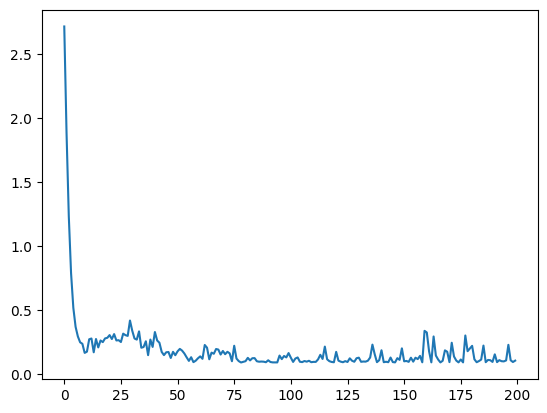

In [ ]:
# Visualize learning (training loss)
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
plt = sns.lineplot(x=loss_indices, y=losses_float)
plt

In [ ]:
#Testing the model by passing in a smiles string
Smiles = ['C1cccc1']
f_smiles = featurizer.featurize(Smiles)
with torch.inference_mode():
  pred, emb = model(torch.tensor(f_smiles[0].node_features).float().to(device), torch.tensor(f_smiles[0].edge_index).to(device), torch.tensor([1]).to(device))
print(pred[0])

tensor([[-3.0717],
        [-2.6719]], device='cuda:0')


In [ ]:
#Saving the model
PATH = 'GNN_Model.pt'
torch.save(model.state_dict(), PATH)

In [ ]:
#Loading the model
PATH = 'GNN_Model.pt'
model1 = dcmodel()
model1.load_state_dict(torch.load(PATH))
model1

dcmodel(
  (initial_conv): GCNConv(30, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
import pandas as pd

# Analyze the results for one batch
preds = []
test_batch = []
with torch.inference_mode():
  for i in range(len(test_x)):
    pred, embed = model1(torch.tensor(test_x[i]).float(), torch.tensor(test_edge_index[i]), torch.tensor([1]))
    preds.append(pred[1].squeeze().float().item())
  df = pd.DataFrame()
  df["y_real"] = test_y
  df["y_pred"] = preds

df

,y_real,y_pred
0,-6.025,-5.680752
1,-5.190,-4.263744
2,-0.660,-0.043505
3,-4.100,-3.285992
4,-3.900,-2.180971
...,...,...
221,-1.710,-2.936440
222,0.106,-1.339806
223,-3.091,-2.798982
224,-3.180,-3.515668


(<seaborn.axisgrid.JointGrid at 0x7b6a04ecd900>,)

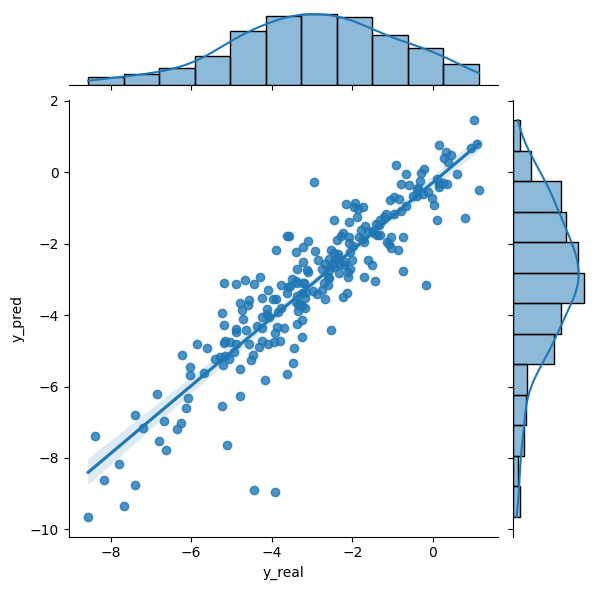

In [ ]:
#Plotting the predicted values vs the original values
import seaborn as sns
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
sns.jointplot(x=df["y_real"], y=df["y_pred"], kind="reg")

In [ ]:
#Calculating the R2 score
print(r2(df["y_real"], df["y_pred"]))

0.811782364598821
